# Sc-candida data 
Convert data to python formats and filter genes

## 0. Loading the libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
sb.set_context('notebook')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'figure.max_open_warning': 0})


from gprofiler import gprofiler

#import sys


import scprep
from umap import UMAP
import graphtools as gt
import meld
import magic

In [3]:
import rpy2
print(rpy2.__version__)

3.4.2


In [4]:
# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
import rpy2.robjects as ro

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects import numpy2ri
numpy2ri.activate()

import anndata2ri
anndata2ri.activate()

%reload_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

import scvi

-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                 8.3.1
anndata             0.7.6
anndata2ri          0.0.0
autoreload          NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2021.05.30
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
colorama            0.4.4
concurrent          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
decorator           4.4.2
defusedxml          0.7.1
deprecated          1.2.12
dunamai             1.6.0
encodings           NA
future              0.18.2
genericpath         NA
get_version         3.5
google              NA
gprofiler           1.0.0
graphtools          1.5.2
h5py                3.3.0
idna                3.2
igraph              0.9.6
ipykernel           6.1.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              3.0.1
joblib             

In [5]:
%%R
.libPaths(R.home("~/anaconda3/envs/scvi-env/lib/R/library"))
library(SingleCellExperiment)
library(here)

<a id="Reading"></a>

## 1. Reading in the data

Here we are loading the gene x cell count matrix after cell filtering using emptyDrops (exp02-emptyDrops_sceQC)

In [6]:
%%R -o adata

adata = readRDS(here("data", "data02-emptyDrops_sceQC", "filtered-sce.rds"))
adata

class: SingleCellExperiment 
dim: 6169 18854 
metadata(0):
assays(2): X logcounts
rownames(6169): CTA2 TUP1 ... CR00650WA CR00720WA
rowData names(0):
colnames(18854): CSP_2_1_FALSE_CGTTTGCAGCTT CSP_2_1_FALSE_GATATCAGGTGC
  ... UT_0_3_FALSE_CGCGTGCCAGGC UT_0_3_FALSE_GTGGGTTAGCTT
colData names(15): orig.ident nCount_RNA ... subsets_Ribo_percent total
reducedDimNames(0):
altExpNames(0):


In [7]:
adata

AnnData object with n_obs × n_vars = 18854 × 6169
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'drug', 'day', 'batch', 'nruns', 'drug_day', 'ident', 'sum', 'detected', 'subsets_Ribo_sum', 'subsets_Ribo_detected', 'subsets_Ribo_percent', 'total'
    layers: 'logcounts'

In [8]:
# Annotate the data sets
print(adata.obs['orig.ident'].value_counts())
print('')
print(adata.obs['drug'].value_counts())
print('')
print(adata.obs['nruns'].value_counts())
print('')

UT_0_1_FALSE      2736
FCZ_6_3_FALSE     2483
RAPA_2_2_FALSE    2460
FCZ_2_2_FALSE     2444
CSP_2_1_FALSE     2075
UT_0_3_FALSE      2050
FCZ_3_2_FALSE     1616
FCZ_2_1_FALSE      948
FCZ_3_3_FALSE      908
FCZ_3_1_FALSE      858
UT_0_2_FALSE       276
Name: orig.ident, dtype: int64

FCZ     9257
UT      5062
RAPA    2460
CSP     2075
Name: drug, dtype: int64

3.0    12237
2.0     6617
Name: nruns, dtype: int64



In [9]:
# Checking the total size of the data set
adata.shape

(18854, 6169)

<a id="Preprocessing"></a>

## 2. Filtering genes

<a id="QC"></a>

In [10]:
adata.X

<18854x6169 sparse matrix of type '<class 'numpy.float32'>'
	with 1768466 stored elements in Compressed Sparse Row format>

In [11]:
adata.obs['nCount_RNA']

CSP_2_1_FALSE_CGTTTGCAGCTT    346.0
CSP_2_1_FALSE_GATATCAGGTGC    486.0
CSP_2_1_FALSE_CTGCGCTCTAAA    414.0
CSP_2_1_FALSE_GGGTATTCATAT    366.0
CSP_2_1_FALSE_AAGCTAGGACGC    286.0
                              ...  
UT_0_3_FALSE_CCACTGGATTCC      81.0
UT_0_3_FALSE_GCATTTGATGAT      83.0
UT_0_3_FALSE_AGGGGCGTAGAT      82.0
UT_0_3_FALSE_CGCGTGCCAGGC      85.0
UT_0_3_FALSE_GTGGGTTAGCTT      90.0
Name: nCount_RNA, Length: 18854, dtype: float64

In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.X.sum(1))
adata.obs['n_genes'] = (adata.X > 0).sum(1)

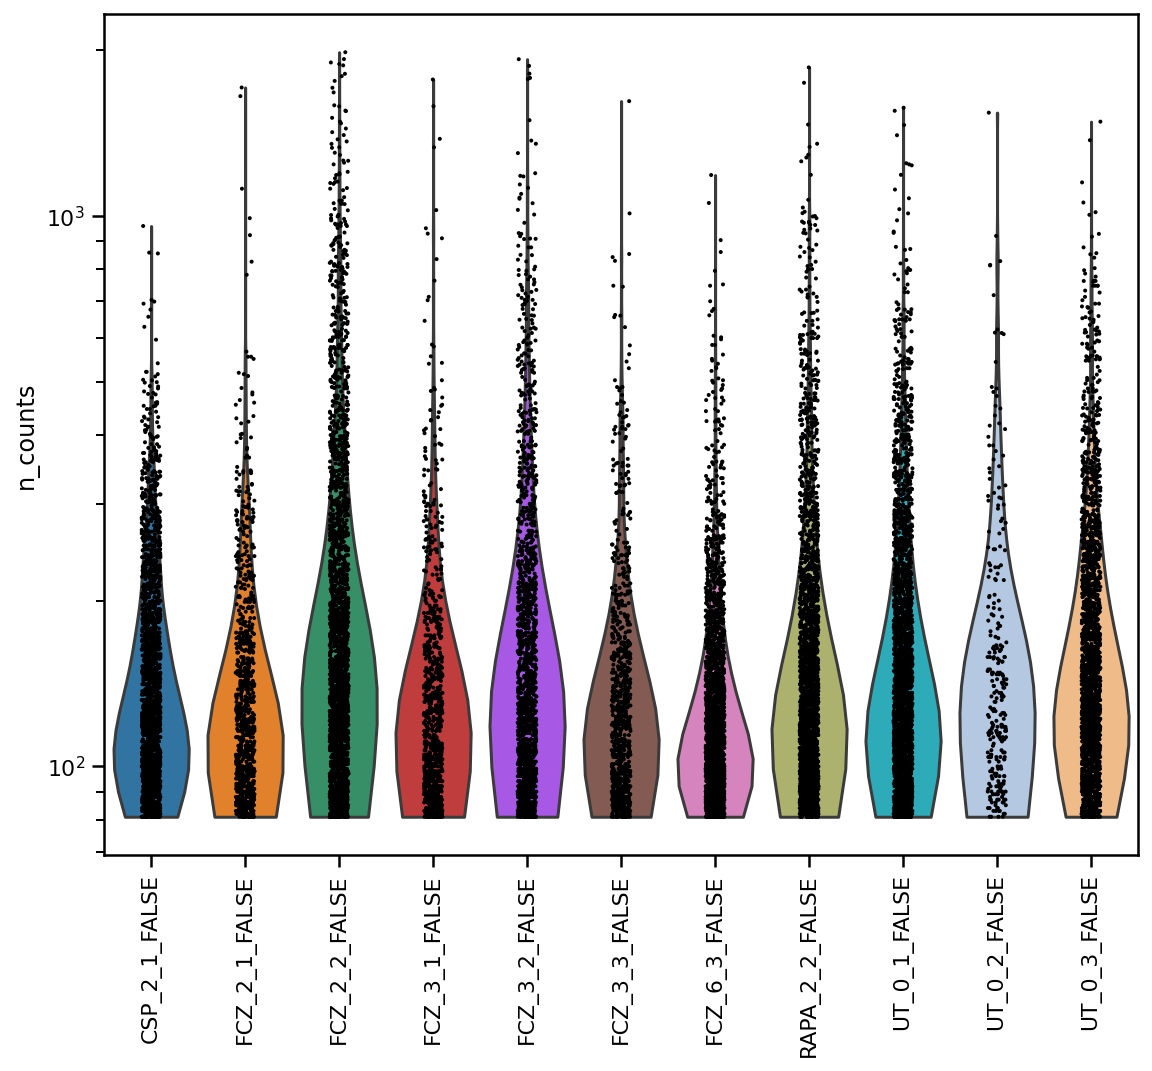

In [15]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0,save="raw_counts.png")

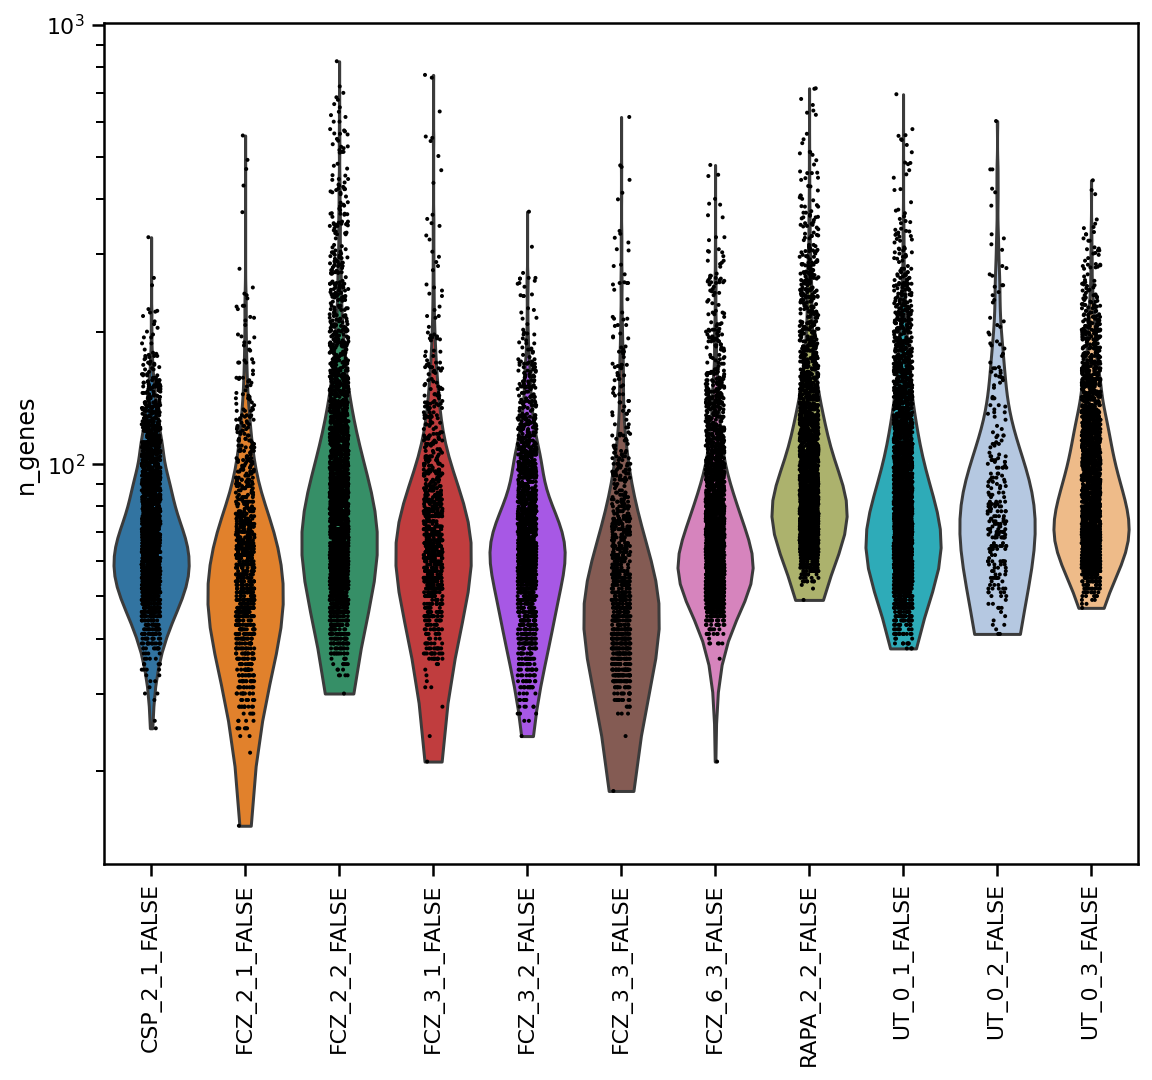

In [16]:
t1 = sc.pl.violin(adata, 'n_genes', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0,save="raw_genes.png")

In [17]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 10)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 2000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

#adata = adata[adata.obs['subsets_Ribo_percent'] < 0.70]
#print('Number of cells after ribo filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 10)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))


Total number of cells: 18854
Number of cells after min count filter: 18854
Number of cells after max count filter: 18854
Number of cells after gene filter: 18854


In [18]:
# Annotate the data sets
print(adata.obs['orig.ident'].value_counts())
print('')
print(adata.obs['drug'].value_counts())
print('')
print(adata.obs['nruns'].value_counts())
print('')

UT_0_1_FALSE      2736
FCZ_6_3_FALSE     2483
RAPA_2_2_FALSE    2460
FCZ_2_2_FALSE     2444
CSP_2_1_FALSE     2075
UT_0_3_FALSE      2050
FCZ_3_2_FALSE     1616
FCZ_2_1_FALSE      948
FCZ_3_3_FALSE      908
FCZ_3_1_FALSE      858
UT_0_2_FALSE       276
Name: orig.ident, dtype: int64

FCZ     9257
UT      5062
RAPA    2460
CSP     2075
Name: drug, dtype: int64

3.0    12237
2.0     6617
Name: nruns, dtype: int64



In [19]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after gene filter: {:d}'.format(adata.n_vars))

Total number of genes: 6169
filtered out 892 genes that are detected in less than 20 cells
Number of genes after gene filter: 5277


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

In [20]:
# Annotate the data sets
print(adata.obs['orig.ident'].value_counts())
print('')
print(adata.obs['drug'].value_counts())
print('')

UT_0_1_FALSE      2736
FCZ_6_3_FALSE     2483
RAPA_2_2_FALSE    2460
FCZ_2_2_FALSE     2444
CSP_2_1_FALSE     2075
UT_0_3_FALSE      2050
FCZ_3_2_FALSE     1616
FCZ_2_1_FALSE      948
FCZ_3_3_FALSE      908
FCZ_3_1_FALSE      858
UT_0_2_FALSE       276
Name: orig.ident, dtype: int64

FCZ     9257
UT      5062
RAPA    2460
CSP     2075
Name: drug, dtype: int64



In [21]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,drug,day,batch,nruns,drug_day,ident,sum,detected,subsets_Ribo_sum,subsets_Ribo_detected,subsets_Ribo_percent,total,n_counts,log_counts,n_genes
CSP_2_1_FALSE_CGTTTGCAGCTT,CSP_2_1_FALSE,346.0,132,CSP,2,1,2.0,CSP_2,CSP_2_1_FALSE,346.0,132,163.0,42,47.109827,346.0,346.0,5.846439,132
CSP_2_1_FALSE_GATATCAGGTGC,CSP_2_1_FALSE,486.0,177,CSP,2,1,2.0,CSP_2,CSP_2_1_FALSE,486.0,177,227.0,49,46.707819,486.0,486.0,6.186209,177
CSP_2_1_FALSE_CTGCGCTCTAAA,CSP_2_1_FALSE,414.0,170,CSP,2,1,2.0,CSP_2,CSP_2_1_FALSE,414.0,170,199.0,57,48.067633,414.0,414.0,6.025866,170
CSP_2_1_FALSE_GGGTATTCATAT,CSP_2_1_FALSE,366.0,155,CSP,2,1,2.0,CSP_2,CSP_2_1_FALSE,366.0,155,184.0,52,50.273224,366.0,366.0,5.902633,155
CSP_2_1_FALSE_AAGCTAGGACGC,CSP_2_1_FALSE,286.0,131,CSP,2,1,2.0,CSP_2,CSP_2_1_FALSE,286.0,131,136.0,43,47.552448,286.0,286.0,5.655992,131


In [22]:
np.mean(adata.obs['n_counts'])

184.21263

In [23]:
max(adata.obs['n_counts'])

1984.0

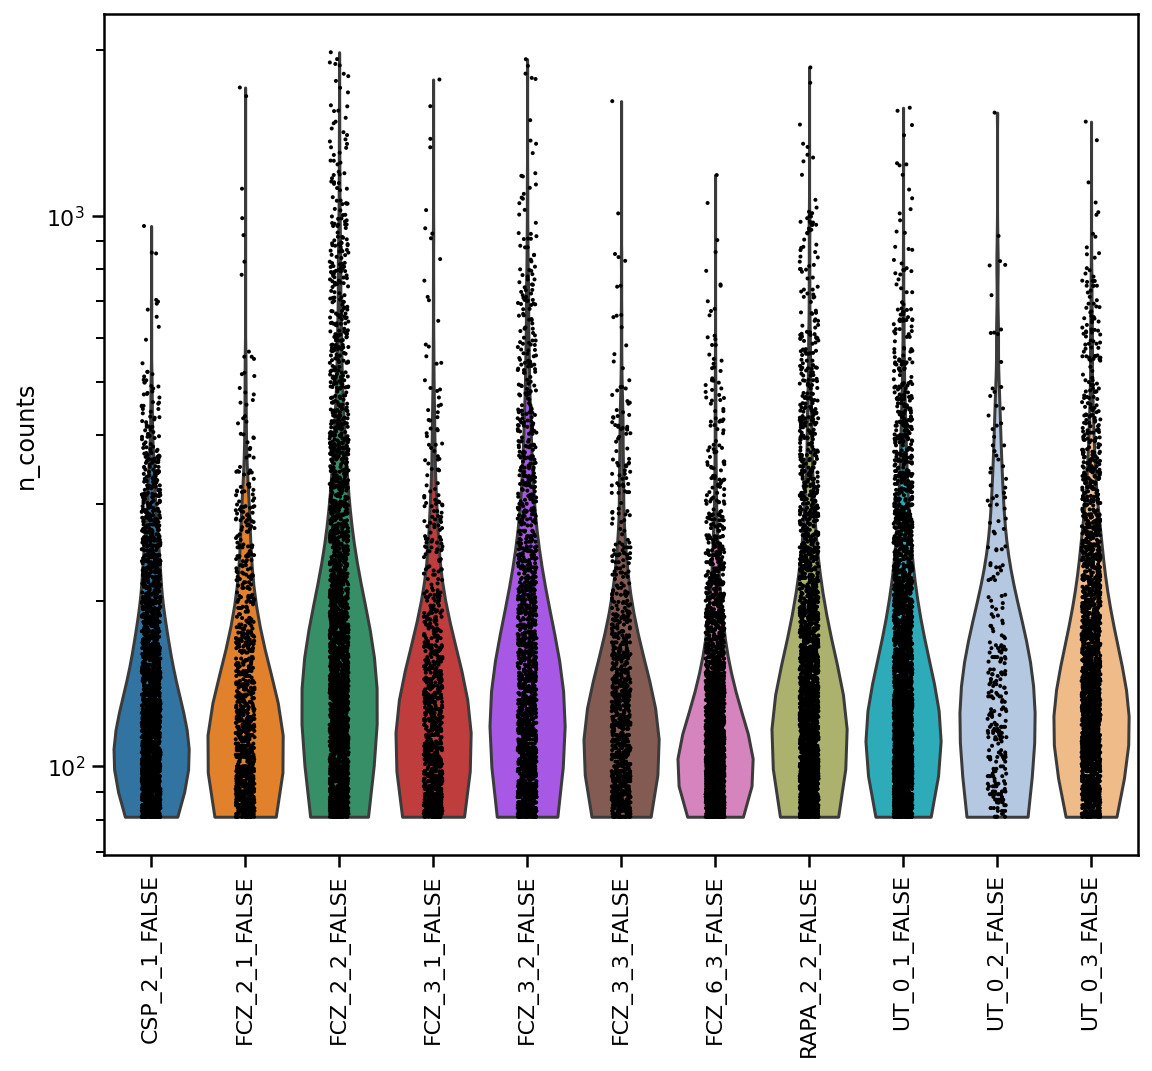

In [24]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0)

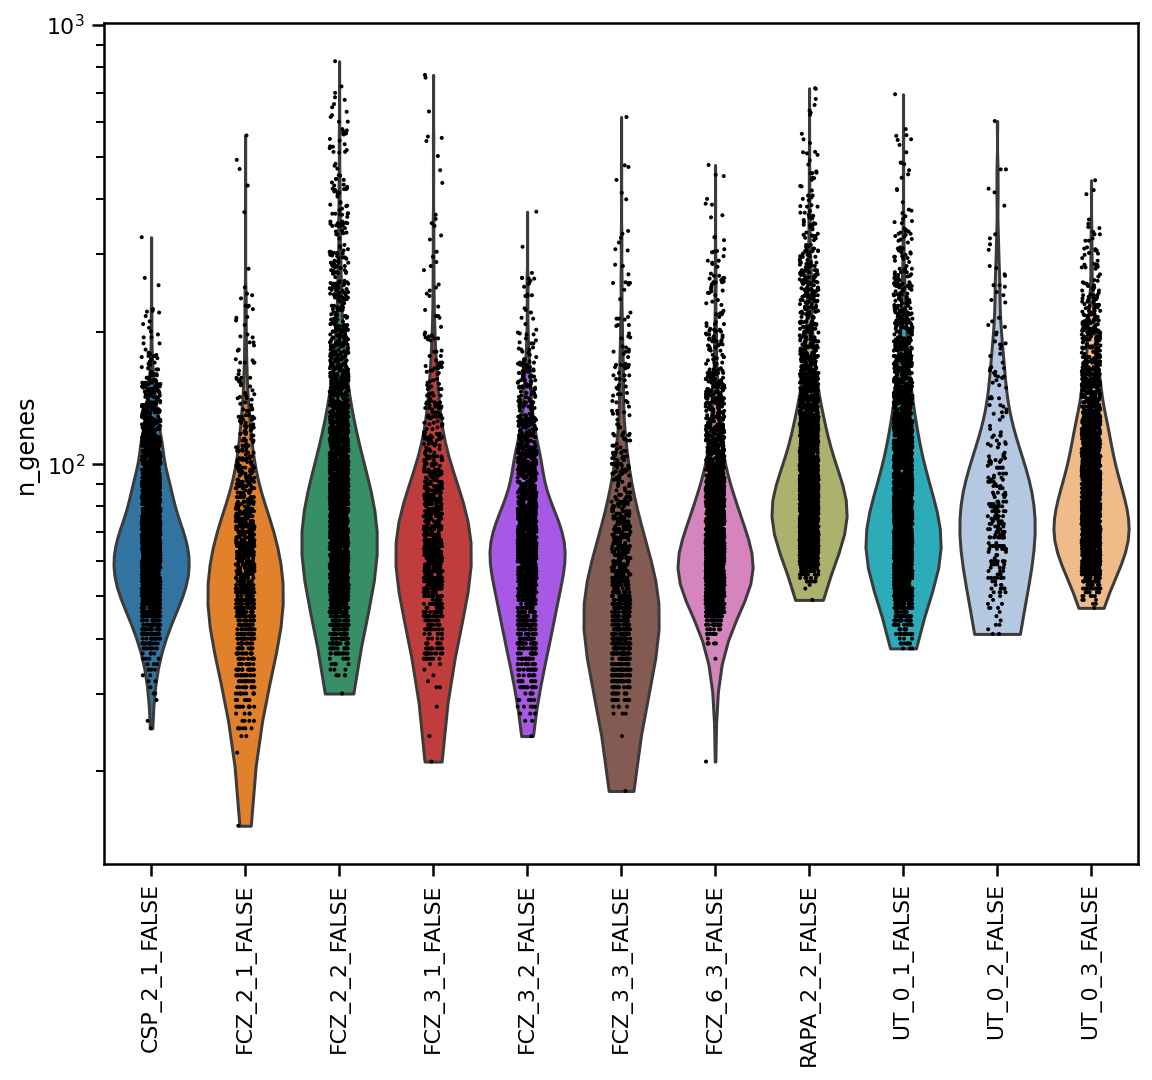

In [25]:
t1 = sc.pl.violin(adata, 'n_genes', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0)

In [26]:
np.mean(adata.obs['n_genes'])

93.79792086559881

In [27]:
max(adata.obs['n_genes'])

825

## 3. Save anndata

In [28]:
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype(int)
adata.obs["detected"] = adata.obs["detected"].astype(int)
adata.obs["subsets_Ribo_detected"] = adata.obs["subsets_Ribo_detected"].astype(float)
adata.write('../../data/data03-scvi/finalall-adata.h5ad')

In [29]:
adata.obs.to_csv("../../data/data03-scvi/finalall-adjLogcounts_labels.csv")
t=adata.X.toarray()
pd.DataFrame(data=t, index=adata.obs_names, columns=adata.var_names).to_csv('../../data/data03-scvi/finalall_raw.csv')